# Delete CentralApnea

In [9]:
import pandas as pd

In [10]:
df = pd.read_csv(r"C:\V89\Snore_Apnea_Analyze\EDF_RML\data_csv\respiratory_plus_normal.csv")

In [11]:
df['type'].value_counts()

type
Normal              912
ObstructiveApnea    649
Hypopnea            398
MixedApnea           72
CentralApnea         38
Name: count, dtype: int64

In [12]:
import pandas as pd

# Load your CSV
df = pd.read_csv(r"C:\V89\Snore_Apnea_Analyze\EDF_RML\data_csv\respiratory_plus_normal.csv")

# Remove rows where 'type' is 'ObstructiveApnea'
df_filtered = df[df['type'] != 'ObstructiveApnea']

# Save the new CSV
df_filtered.to_csv(r"C:\V89\Snore_Apnea_Analyze\EDF_RML\data_csv\respiratory_without_obstructive.csv", index=False)

# Check result
print(df_filtered['type'].value_counts())


type
Normal          912
Hypopnea        398
MixedApnea       72
CentralApnea     38
Name: count, dtype: int64


In [13]:
import pandas as pd

# Load CSV (ใช้ไฟล์ที่ตัด ObstructiveApnea ออกแล้ว)
df = pd.read_csv(r"C:\V89\Snore_Apnea_Analyze\EDF_RML\data_csv\respiratory_without_obstructive.csv")

# รวมทุก class ที่ไม่ใช่ Normal ให้เป็น "Apnea"
df['type'] = df['type'].apply(lambda x: 'Normal' if x == 'Normal' else 'Apnea')

# Save เป็นไฟล์ใหม่
df.to_csv(r"C:\V89\Snore_Apnea_Analyze\EDF_RML\data_csv\respiratory_binary_v2.csv", index=False)

# ตรวจสอบจำนวน class
print(df['type'].value_counts())


type
Normal    912
Apnea     508
Name: count, dtype: int64


# Model

In [14]:
# ===== Cell 1: Import libraries =====
import os, json, time, random, re
from pathlib import Path
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

try:
    import torchaudio
    HAVE_TA = True
except Exception:
    HAVE_TA = False
    print("[WARN] torchaudio not found, augmentation disabled.")

import pyedflib
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, f1_score, precision_recall_fscore_support,
    classification_report, confusion_matrix, roc_auc_score,
    log_loss, average_precision_score
)

from transformers import (
    Wav2Vec2Processor, Wav2Vec2ForSequenceClassification,
    get_linear_schedule_with_warmup
)

print("✅ All libraries imported successfully!")


✅ All libraries imported successfully!


In [15]:
# ===== Cell 2: Device & seed =====
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if device.type == "cuda":
    print(f"GPU: {torch.cuda.get_device_name()}")
    print(f"CUDA Version: {torch.version.cuda}")
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


Using device: cuda
GPU: NVIDIA GeForce RTX 4060
CUDA Version: 11.8


In [16]:
# ===== Cell 3: Load CSV and convert to binary classes =====
df = pd.read_csv(r"C:\V89\Snore_Apnea_Analyze\EDF_RML\data_csv\respiratory_binary_v2.csv")
EDF_ROOT = r"C:\V89\data2"

In [17]:
df['patient_id'].value_counts()

patient_id
995     374
999     286
1008    222
1006    217
1000    205
1089    116
Name: count, dtype: int64

In [18]:
from sklearn.preprocessing import LabelEncoder

# สมมติ df ตอนนี้มี column 'type' = ['Normal', 'Apnea', ...]
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['type'])

print(df['type'].value_counts())
print("Label mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))


type
Normal    912
Apnea     508
Name: count, dtype: int64
Label mapping: {'Apnea': np.int64(0), 'Normal': np.int64(1)}


In [ ]:
class SnoreApneaDataset(Dataset):
    def __init__(self, dataframe, processor, edf_root, target_sr=16000):
        self.df = dataframe.reset_index(drop=True)
        self.processor = processor
        self.edf_root = Path(edf_root)
        self.target_sr = target_sr

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # สร้างชื่อไฟล์ EDF
        edf_filename = f"{row['patient_id']:08d}-100507[{row['segment_index']+1:03d}].edf"
        edf_path = self.edf_root / edf_filename

        label = row['label']

        with pyedflib.EdfReader(str(edf_path)) as f:
            sig_idx = f.getSignalLabels().index('Snore')  # หรือ 'Mic', 'Trachea'
            waveform = f.readSignal(sig_idx)

        waveform = torch.tensor(waveform, dtype=torch.float32)

        if HAVE_TA:
            waveform = torchaudio.transforms.Resample(
                orig_freq=f.getSampleFrequency(sig_idx),
                new_freq=self.target_sr
            )(waveform)

        inputs = self.processor(
            waveform.numpy(),
            sampling_rate=self.target_sr,
            return_tensors="pt",
            padding=True
        )

        return {
            'input_values': inputs.input_values.squeeze(0),
            'attention_mask': inputs.attention_mask.squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [20]:
# ===== Cell 5: Prepare processor & dataloaders =====
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
train_df = df.sample(frac=0.8, random_state=SEED)
val_df = df.drop(train_df.index)

train_dataset = SnoreApneaDataset(train_df, processor, EDF_ROOT)
val_dataset = SnoreApneaDataset(val_df, processor, EDF_ROOT)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)


c:\V89\.venv\Lib\site-packages\transformers\configuration_utils.py:381: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


In [21]:
# ===== Cell 6: Model initialization =====
model = Wav2Vec2ForSequenceClassification.from_pretrained(
    "facebook/wav2vec2-base",
    num_labels=2  # Only 2 classes now
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
total_steps = len(train_loader) * 5  # 5 epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
loss_fn = nn.CrossEntropyLoss()


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['projector.weight', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'projector.bias', 'classifier.weight', 'classifier.bias', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [93]:
# ===== Cell 7: Training loop with accuracy =====
for epoch in range(3):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        optimizer.zero_grad()
        input_values = batch['input_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_values, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()

        # Accuracy calculation
        preds = torch.argmax(outputs.logits, dim=-1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = train_loss / len(train_loader)
    epoch_acc = correct / total

    print(f"Epoch {epoch+1} - Train Loss: {epoch_loss:.4f} - Train Acc: {epoch_acc:.4f}")


Epoch 1:   0%|          | 0/142 [00:00<?, ?it/s]

c:\V89\.venv\Lib\site-packages\torch\_dynamo\eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Epoch 1 - Train Loss: 0.6584 - Train Acc: 0.6294


Epoch 2:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 2 - Train Loss: 0.6428 - Train Acc: 0.6470


Epoch 3:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 3 - Train Loss: 0.6031 - Train Acc: 0.7095


In [2]:
# ===== Save model after training =====
save_dir = "C:\V89\Snore_Apnea_Analyze\EDF_RML\ิbinary_mic_snore"
model.save_pretrained(save_dir)
processor.save_pretrained(save_dir)  # ถ้าใช้ Wav2Vec2/processor

print(f"✅ Model saved to {save_dir}")


NameError: name 'model' is not defined

## Eval

In [22]:
# ===== Cell 2: Device & seed =====
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if device.type == "cuda":
    print(f"GPU: {torch.cuda.get_device_name()}")
    print(f"CUDA Version: {torch.version.cuda}")
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

Using device: cuda
GPU: NVIDIA GeForce RTX 4060
CUDA Version: 11.8


In [23]:
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2Processor
import torch

# Path to saved model
model_path = r"C:\V89\Snore_Apnea_Analyze\EDF_RML\ิbinary_mic_snore"

# Load model + processor
model = Wav2Vec2ForSequenceClassification.from_pretrained(model_path)
processor = Wav2Vec2Processor.from_pretrained(model_path)

model.to(device)
model.eval()

Wav2Vec2ForSequenceClassification(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)


BINARY CLASSIFICATION REPORT:
              precision    recall  f1-score   support

       Apnea       1.00      0.23      0.38        91
      Normal       0.73      1.00      0.85       193

    accuracy                           0.75       284
   macro avg       0.87      0.62      0.61       284
weighted avg       0.82      0.75      0.70       284


BINARY METRICS:
ROC-AUC Score: 0.6893
PR-AUC Score: 0.7939


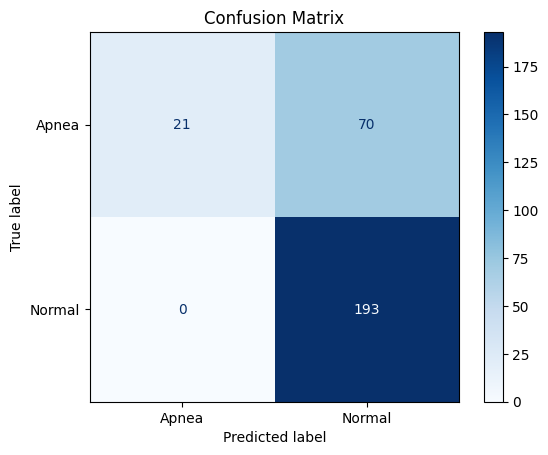

In [24]:
# ===== Cell 9: Full evaluation with metrics and confusion matrix =====
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, average_precision_score

model.eval()    
y_true, y_pred, y_score = [], [], []
with torch.no_grad():
    for batch in val_loader:
        input_values = batch['input_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_values, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_score.extend(torch.softmax(logits, dim=1)[:, 1].cpu().numpy())  # Prob for class 1 (Apnea)

# Classification report
print("BINARY CLASSIFICATION REPORT:")
print("="*40)
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# Metrics
roc_auc = roc_auc_score(y_true, y_score)
pr_auc = average_precision_score(y_true, y_score)
print("\nBINARY METRICS:")
print(f"ROC-AUC Score: {roc_auc:.4f}")
print(f"PR-AUC Score: {pr_auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


# 